<ipython-input-6-774e3e0295c6>:103: RuntimeWarning: overflow encountered in scalar subtract
  sum_val -= integral[a - 1, d]
<ipython-input-6-774e3e0295c6>:105: RuntimeWarning: overflow encountered in scalar add
  sum_val += integral[a - 1, c - 1]


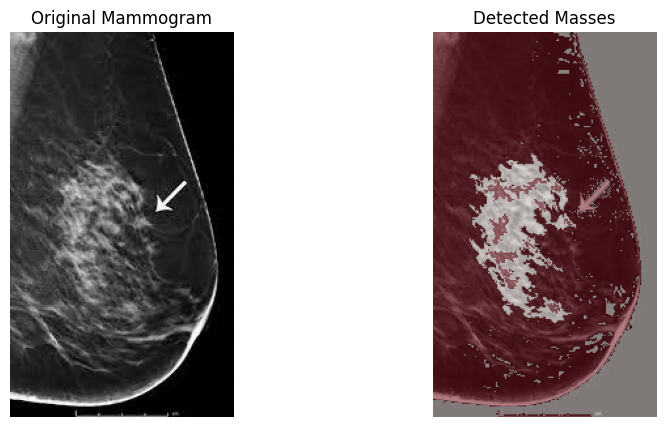

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to load and convert image to grayscale
def load_image(filename):
    """
    Load an image file and convert it to grayscale.

    Args:
        filename (str): Path to the image file.
    Returns:
        numpy.ndarray: Grayscale image as a 2D array.
    """
    img = Image.open(filename).convert('L')  # 'L' mode for grayscale
    return np.array(img)

# Function to compute Otsu's threshold
def otsu_threshold(image):
    """
    Implement Otsu's method to find the optimal threshold for binarization.

    Args:
        image (numpy.ndarray): Grayscale image.
    Returns:
        int: Optimal threshold value.
    """
    # Compute histogram of pixel intensities (0 to 255)
    h, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))
    N = image.size  # Total number of pixels
    cumsum_h = np.cumsum(h)  # Cumulative sum of histogram
    cumsum_ih = np.cumsum(np.arange(256) * h)  # Cumulative sum of intensity * histogram

    variances = []
    for t in range(1, 256):
        w_b = cumsum_h[t]  # Weight of background class
        w_f = N - w_b      # Weight of foreground class
        if w_b == 0 or w_f == 0:
            variances.append(0)
            continue
        mu_b = cumsum_ih[t] / w_b  # Mean of background
        mu_f = (cumsum_ih[-1] - cumsum_ih[t]) / w_f  # Mean of foreground
        variance = w_b * w_f * (mu_b - mu_f) ** 2  # Between-class variance
        variances.append(variance)

    t_opt = np.argmax(variances) + 1  # Optimal threshold (index + 1 since t starts at 1)
    return t_opt

# Function for manual connected component labeling
def connected_components(binary_image):
    """
    Label connected components in a binary image using 8-connectivity.

    Args:
        binary_image (numpy.ndarray): Binary image (0s and 1s).
    Returns:
        numpy.ndarray: Labeled image where each component has a unique integer.
    """
    rows, cols = binary_image.shape
    label_image = np.zeros((rows, cols), dtype=int)
    current_label = 0

    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 1 and label_image[i, j] == 0:
                current_label += 1
                queue = [(i, j)]
                while queue:
                    x, y = queue.pop(0)
                    if x < 0 or x >= rows or y < 0 or y >= cols:
                        continue
                    if binary_image[x, y] == 1 and label_image[x, y] == 0:
                        label_image[x, y] = current_label
                        # Add all 8 neighbors
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx != 0 or dy != 0:
                                    queue.append((x + dx, y + dy))
    return label_image

# Function to compute sum over a window using integral image
def local_sum(integral, i, j, w, rows, cols):
    """
    Calculate the sum of values in a window using an integral image.

    Args:
        integral (numpy.ndarray): Integral image.
        i, j (int): Center pixel coordinates.
        w (int): Half-window size.
        rows, cols (int): Image dimensions.
    Returns:
        float: Sum of values in the window.
    """
    a = max(0, i - w)          # Top boundary
    b = min(rows - 1, i + w)   # Bottom boundary
    c = max(0, j - w)          # Left boundary
    d = min(cols - 1, j + w)   # Right boundary

    sum_val = integral[b, d]
    if c > 0:
        sum_val -= integral[b, c - 1]
    if a > 0:
        sum_val -= integral[a - 1, d]
    if a > 0 and c > 0:
        sum_val += integral[a - 1, c - 1]
    return sum_val

# Main function to detect masses
def detect_masses(image, w=25, C=20, min_area=100):
    """
    Detect potential masses in a mammogram image.

    Args:
        image (numpy.ndarray): Grayscale mammogram image.
        w (int): Half-window size for local mean calculation.
        C (int): Threshold offset for mass detection.
        min_area (int): Minimum area for a region to be considered a mass.
    Returns:
        numpy.ndarray: Binary mask of detected masses.
    """
    # Step 1: Segment breast region using Otsu's method
    t = otsu_threshold(image)
    breast_mask = (image > t).astype(np.uint8)

    # Step 2: Select largest connected component as breast region
    label_image = connected_components(breast_mask)
    sizes = np.bincount(label_image.flatten())[1:]  # Exclude label 0
    breast_label = np.argmax(sizes) + 1  # +1 because sizes index starts at label 1
    breast_mask = (label_image == breast_label).astype(np.uint8)

    # Step 3: Compute integral images
    breast_image = image * breast_mask  # Masked image
    integral_image = np.cumsum(np.cumsum(breast_image, axis=0), axis=1)
    integral_mask = np.cumsum(np.cumsum(breast_mask, axis=0), axis=1)

    # Step 4: Compute local mean for breast region pixels
    rows, cols = image.shape
    local_mean = np.zeros_like(image, dtype=float)
    for i in range(rows):
        for j in range(cols):
            if breast_mask[i, j]:
                sum_image = local_sum(integral_image, i, j, w, rows, cols)
                sum_mask = local_sum(integral_mask, i, j, w, rows, cols)
                if sum_mask > 0:
                    local_mean[i, j] = sum_image / sum_mask

    # Step 5: Detect potential masses
    diff = image - local_mean
    potential_mass = (diff > C).astype(np.uint8)

    # Step 6: Filter by size
    label_potential = connected_components(potential_mass)
    sizes = np.bincount(label_potential.flatten())[1:]
    large_labels = np.where(sizes > min_area)[0] + 1
    mass_mask = np.isin(label_potential, large_labels)

    return mass_mask

# Main execution function
def main():
    """
    Load an image, detect masses, and display the results.
    """
    filename = '/content/sample_data/images.jpg'  # Replace with your mammogram image path
    try:
        image = load_image(filename)
    except FileNotFoundError:
        print(f"Error: Image file '{filename}' not found.")
        return

    # Detect masses with default parameters
    mass_mask = detect_masses(image, w=25, C=20, min_area=100)

    # Visualize results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Mammogram')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Detected Masses')
    plt.imshow(image, cmap='gray')
    plt.imshow(mass_mask, cmap='Reds', alpha=0.5)  # Overlay masses in red
    plt.axis('off')

    plt.show()

if __name__ == '__main__':
    main()

<ipython-input-7-45acbbed9639>:101: RuntimeWarning: overflow encountered in scalar subtract
  sum_val -= integral[a - 1, d]
<ipython-input-7-45acbbed9639>:103: RuntimeWarning: overflow encountered in scalar add
  sum_val += integral[a - 1, c - 1]


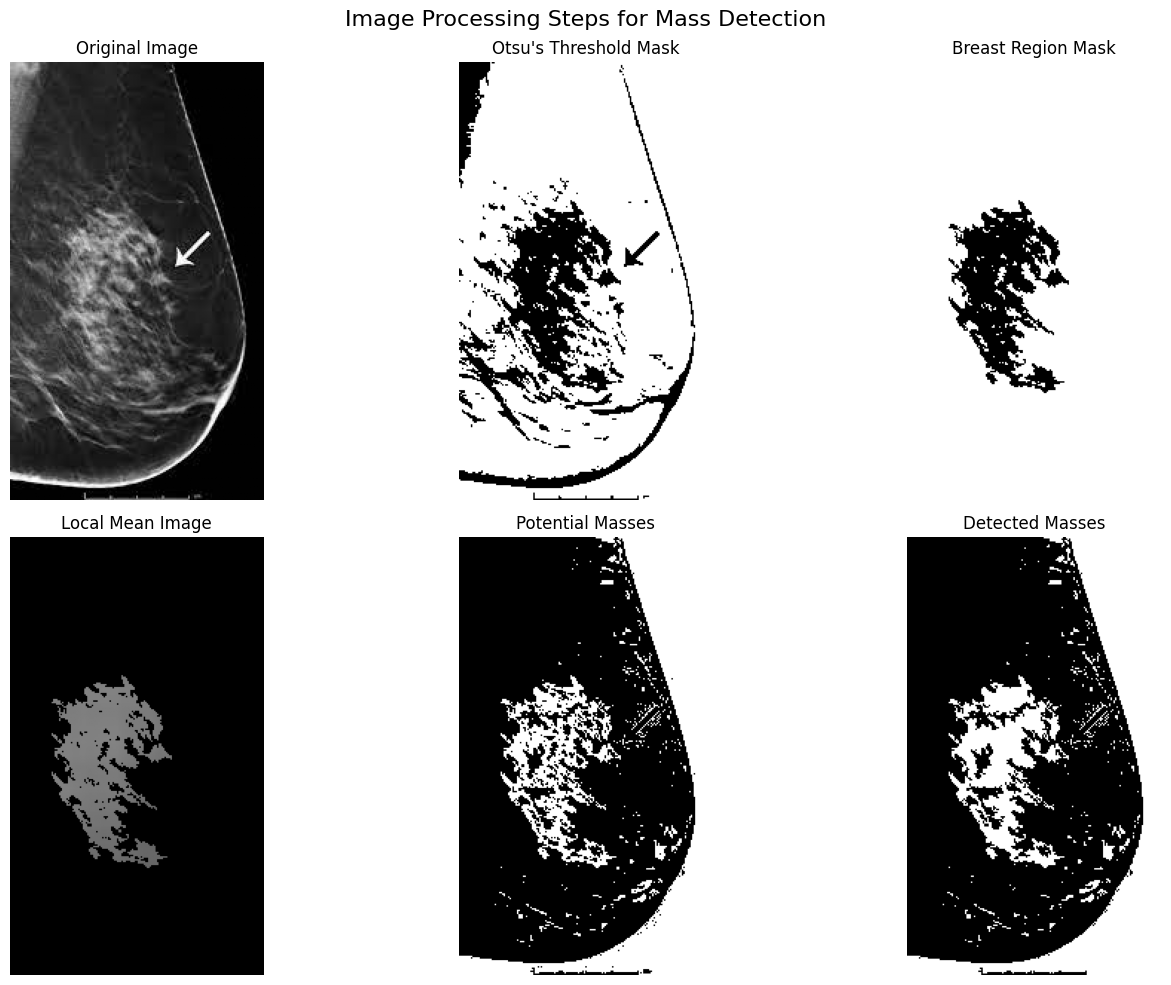

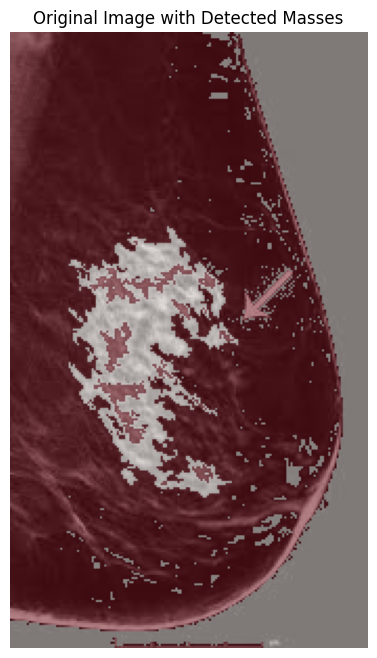

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to load and convert image to grayscale
def load_image(filename):
    """
    Load an image file and convert it to grayscale.

    Args:
        filename (str): Path to the image file.
    Returns:
        numpy.ndarray: Grayscale image as a 2D array.
    """
    img = Image.open(filename).convert('L')  # 'L' mode for grayscale
    return np.array(img)

# Function to compute Otsu's threshold
def otsu_threshold(image):
    """
    Implement Otsu's method to find the optimal threshold for binarization.

    Args:
        image (numpy.ndarray): Grayscale image.
    Returns:
        int: Optimal threshold value.
    """
    h, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))
    N = image.size
    cumsum_h = np.cumsum(h)
    cumsum_ih = np.cumsum(np.arange(256) * h)

    variances = []
    for t in range(1, 256):
        w_b = cumsum_h[t]
        w_f = N - w_b
        if w_b == 0 or w_f == 0:
            variances.append(0)
            continue
        mu_b = cumsum_ih[t] / w_b
        mu_f = (cumsum_ih[-1] - cumsum_ih[t]) / w_f
        variance = w_b * w_f * (mu_b - mu_f) ** 2
        variances.append(variance)

    t_opt = np.argmax(variances) + 1
    return t_opt

# Function for manual connected component labeling
def connected_components(binary_image):
    """
    Label connected components in a binary image using 8-connectivity.

    Args:
        binary_image (numpy.ndarray): Binary image (0s and 1s).
    Returns:
        numpy.ndarray: Labeled image where each component has a unique integer.
    """
    rows, cols = binary_image.shape
    label_image = np.zeros((rows, cols), dtype=int)
    current_label = 0

    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 1 and label_image[i, j] == 0:
                current_label += 1
                queue = [(i, j)]
                while queue:
                    x, y = queue.pop(0)
                    if x < 0 or x >= rows or y < 0 or y >= cols:
                        continue
                    if binary_image[x, y] == 1 and label_image[x, y] == 0:
                        label_image[x, y] = current_label
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx != 0 or dy != 0:
                                    queue.append((x + dx, y + dy))
    return label_image

# Function to compute sum over a window using integral image
def local_sum(integral, i, j, w, rows, cols):
    """
    Calculate the sum of values in a window using an integral image.

    Args:
        integral (numpy.ndarray): Integral image.
        i, j (int): Center pixel coordinates.
        w (int): Half-window size.
        rows, cols (int): Image dimensions.
    Returns:
        float: Sum of values in the window.
    """
    a = max(0, i - w)
    b = min(rows - 1, i + w)
    c = max(0, j - w)
    d = min(cols - 1, j + w)

    sum_val = integral[b, d]
    if c > 0:
        sum_val -= integral[b, c - 1]
    if a > 0:
        sum_val -= integral[a - 1, d]
    if a > 0 and c > 0:
        sum_val += integral[a - 1, c - 1]
    return sum_val

# Main function to detect masses and return intermediate results
def detect_masses(image, w=25, C=20, min_area=100):
    """
    Detect potential masses in a mammogram image and return intermediate results.

    Args:
        image (numpy.ndarray): Grayscale mammogram image.
        w (int): Half-window size for local mean calculation.
        C (int): Threshold offset for mass detection.
        min_area (int): Minimum area for a region to be considered a mass.
    Returns:
        dict: Dictionary containing intermediate processing results.
    """
    # Step 1: Segment breast region using Otsu's method
    t = otsu_threshold(image)
    otsu_mask = (image > t).astype(np.uint8)

    # Step 2: Select largest connected component as breast region
    label_image = connected_components(otsu_mask)
    sizes = np.bincount(label_image.flatten())[1:]
    breast_label = np.argmax(sizes) + 1
    breast_mask = (label_image == breast_label).astype(np.uint8)

    # Step 3: Compute integral images
    breast_image = image * breast_mask
    integral_image = np.cumsum(np.cumsum(breast_image, axis=0), axis=1)
    integral_mask = np.cumsum(np.cumsum(breast_mask, axis=0), axis=1)

    # Step 4: Compute local mean for breast region pixels
    rows, cols = image.shape
    local_mean = np.zeros_like(image, dtype=float)
    for i in range(rows):
        for j in range(cols):
            if breast_mask[i, j]:
                sum_image = local_sum(integral_image, i, j, w, rows, cols)
                sum_mask = local_sum(integral_mask, i, j, w, rows, cols)
                if sum_mask > 0:
                    local_mean[i, j] = sum_image / sum_mask

    # Step 5: Detect potential masses
    diff = image - local_mean
    potential_mass = (diff > C).astype(np.uint8)

    # Step 6: Filter by size
    label_potential = connected_components(potential_mass)
    sizes = np.bincount(label_potential.flatten())[1:]
    large_labels = np.where(sizes > min_area)[0] + 1
    mass_mask = np.isin(label_potential, large_labels)

    return {
        'original': image,
        'otsu_mask': otsu_mask,
        'breast_mask': breast_mask,
        'local_mean': local_mean,
        'potential_mass': potential_mass,
        'mass_mask': mass_mask
    }

# Main execution function
def main():
    """
    Load an image, detect masses, and display the results with intermediate steps.
    """
    filename = "/content/sample_data/images.jpg"  # Replace with your mammogram image path
    try:
        image = load_image(filename)
    except FileNotFoundError:
        print(f"Error: Image file '{filename}' not found.")
        return

    # Detect masses with default parameters
    results = detect_masses(image, w=25, C=20, min_area=100)

    # Plotting intermediate steps
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot original image
    axes[0].imshow(results['original'], cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot Otsu's mask
    axes[1].imshow(results['otsu_mask'], cmap='binary')
    axes[1].set_title("Otsu's Threshold Mask")
    axes[1].axis('off')

    # Plot breast region mask
    axes[2].imshow(results['breast_mask'], cmap='binary')
    axes[2].set_title('Breast Region Mask')
    axes[2].axis('off')

    # Plot local mean image
    axes[3].imshow(results['local_mean'], cmap='gray', vmin=0, vmax=255)
    axes[3].set_title('Local Mean Image')
    axes[3].axis('off')

    # Plot potential masses
    axes[4].imshow(results['potential_mass'], cmap='binary')
    axes[4].set_title('Potential Masses')
    axes[4].axis('off')

    # Plot final mass mask
    axes[5].imshow(results['mass_mask'], cmap='binary')
    axes[5].set_title('Detected Masses')
    axes[5].axis('off')

    plt.suptitle('Image Processing Steps for Mass Detection', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Final visualization: overlay
    plt.figure(figsize=(8, 8))
    plt.imshow(results['original'], cmap='gray', vmin=0, vmax=255)
    plt.imshow(results['mass_mask'], cmap='Reds', alpha=0.5)
    plt.title('Original Image with Detected Masses')
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    main()